In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook 

Le fichier <a href='http://qa.epidemium.cc/data/epidemiology_dataset/world_bank_data/WorldBank_Data.csv' target='_blank'>WorldBank_Data.csv</a>  contient les colonnes : 
- area_code : code du pays / de la region
- area : nom du pays / de la region
- year : année pour laquelle les indicateurs sont calculés

Les autres colonnes de 3 à 875 représentes les différents indicateurs. Leurs libellés complètes, ainsi que les méthodologies de calcul respectives sont détaillés dans un autre fichier, <a href='http://qa.epidemium.cc/data/epidemiology_dataset/world_bank_data/WorldBank_Indicators.csv' target='_blank'>WorldBank_Indicators.csv</a> 

In [2]:
df_wb = pd.read_csv('WorldBank_Data.csv', sep=',')
df_wb.head()

,area_code,area,year,SE.ADT.1524.LT.FE.ZS,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,...,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.NE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.NE.ZS,SL.UEM.TOTL.ZS,SM.POP.NETM,SM.POP.REFG,SM.POP.REFG.OR,SM.POP.TOTL,SM.POP.TOTL.ZS
0,ABW,Aruba,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7466.0,NaN
1,ABW,Aruba,1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-3537.0,NaN,NaN,NaN,NaN
3,ABW,Aruba,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,1974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_wb_info = pd.read_csv('WorldBank_Indicators.csv', sep=',')
df_wb_info.head()

,Category,Subcategory,Code,Indicator Name,Long definition,Source
0,Economie,National_accounts&Official_development_assista...,DC.DAC.AUSL.CD,"Net bilateral aid flows from DAC donors, Austr...",Net bilateral aid flows from DAC donors are th...,Development Assistance Committee of the Organi...
1,Economie,National_accounts&Official_development_assista...,DC.DAC.AUTL.CD,"Net bilateral aid flows from DAC donors, Austr...",Net bilateral aid flows from DAC donors are th...,Development Assistance Committee of the Organi...
2,Economie,National_accounts&Official_development_assista...,DC.DAC.BELL.CD,"Net bilateral aid flows from DAC donors, Belgi...",Net bilateral aid flows from DAC donors are th...,Development Assistance Committee of the Organi...
3,Economie,National_accounts&Official_development_assista...,DC.DAC.CANL.CD,"Net bilateral aid flows from DAC donors, Canad...",Net bilateral aid flows from DAC donors are th...,Development Assistance Committee of the Organi...
4,Economie,National_accounts&Official_development_assista...,DC.DAC.CECL.CD,"Net bilateral aid flows from DAC donors, Europ...",Net bilateral aid flows from DAC donors are th...,Development Assistance Committee of the Organi...


Afin de récupérer uniquement les pays et non pas les groupes de pays ou autres territoires, on élimine ces derniers à l'aide d'un <a href='https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups' target='_blank'>document</a> fourni par World Bank avec les regroupements utilisés. Les critères de regroupement incluent : région géographique, niveau de revenu, petits états, groupes de prêt, division démographique, autres groupes.

In [4]:
df_groups = pd.read_csv('countries_groups.csv', sep=',')
df_groups.head()

,Grouping_criterion,Group
0,Region,East Asia & Pacific
1,Region,Europe & Central Asia
2,Region,Latin America & Caribbean
3,Region,Middle East & North Africa
4,Region,North America


In [5]:
#codes représentant des groupes et non pas des pays
tmp = pd.merge(df_wb[['area_code', 'area']], 
         df_groups, how='inner', 
         left_on='area', right_on='Group')['area_code']

#exclure groupes
df_wb = df_wb[-df_wb['area_code'].isin(tmp)]

#éliminer colonne redondante (le code du pays n'est jamais utilisé)
df_wb.drop(['area_code'], axis=1, inplace=True)



<font color="#660066" size=6><u>
Choix des indicateurs
</font></u>

On remarque que beaucoup des indicateurs socio-économiques ont des valeurs manquantes, donc on souhaite conserver que ceux pour lesquels le pourcentage de données renseignées est satisfaisant, par exemple au moins 75% des valeurs. 

In [6]:
cutoff = 0.25
nb_na = df_wb.isnull().sum() #calculer nombre de valeurs manquantes par colonne
df_na = pd.DataFrame({'indicator':nb_na.index, 'na_nb':nb_na.values}) 
df_na.sort_values(by=['na_nb'], ascending=False, inplace=True) 
df_na['na_pct'] = df_na['na_nb'] / df_wb.shape[0] #calculer pourcentage de valeurs manquantes

In [7]:
df_indic_info = pd.merge(left=df_wb_info, right=df_na, 
                         how = 'left',
                         left_on = 'Code', right_on = 'indicator')
df_indic_info[df_indic_info['na_pct'] < cutoff].sort_values(by=['na_nb'], ascending=True)

,Category,Subcategory,Code,Indicator Name,Long definition,Source,indicator,na_nb,na_pct
504,Environnement,Environnement,SP.RUR.TOTL.ZS,Rural population (% of total population),Rural population refers to people living in ru...,World Bank staff estimates based on the United...,SP.RUR.TOTL.ZS,56,0.005656
507,Environnement,Environnement,SP.URB.TOTL.IN.ZS,Urban population (% of total),Urban population refers to people living in ur...,The United Nations Population Division's World...,SP.URB.TOTL.IN.ZS,56,0.005656
502,Environnement,Environnement,SP.RUR.TOTL,Rural population,Rural population refers to people living in ru...,World Bank staff estimates based on the United...,SP.RUR.TOTL,59,0.005959
645,Health,Health,SP.POP.TOTL,"Population, total",Total population is based on the de facto defi...,(1) United Nations Population Division. World ...,SP.POP.TOTL,59,0.005959
506,Environnement,Environnement,SP.URB.TOTL,Urban population,Urban population refers to people living in ur...,World Bank staff estimates based on the United...,SP.URB.TOTL,59,0.005959
505,Environnement,Environnement,SP.URB.GROW,Urban population growth (annual %),Urban population refers to people living in ur...,World Bank staff estimates based on the United...,SP.URB.GROW,61,0.006161
644,Health,Health,SP.POP.GROW,Population growth (annual %),Annual population growth rate for year t is th...,Derived from total population. Population sour...,SP.POP.GROW,63,0.006363
267,Education,Education,SE.PRM.DURS,"Primary education, duration (years)",Primary duration refers to the number of grade...,"United Nations Educational, Scientific, and Cu...",SE.PRM.DURS,82,0.008282
252,Education,Education,SE.PRE.DURS,"Preprimary education, duration (years)",Preprimary duration refers to the number of gr...,"United Nations Educational, Scientific, and Cu...",SE.PRE.DURS,130,0.013130
406,Environnement,Environnement,AG.SRF.TOTL.K2,Surface area (sq. km),"Surface area is a country's total area, includ...","Food and Agriculture Organization, electronic ...",AG.SRF.TOTL.K2,158,0.015958


<IPython.core.display.Javascript object>


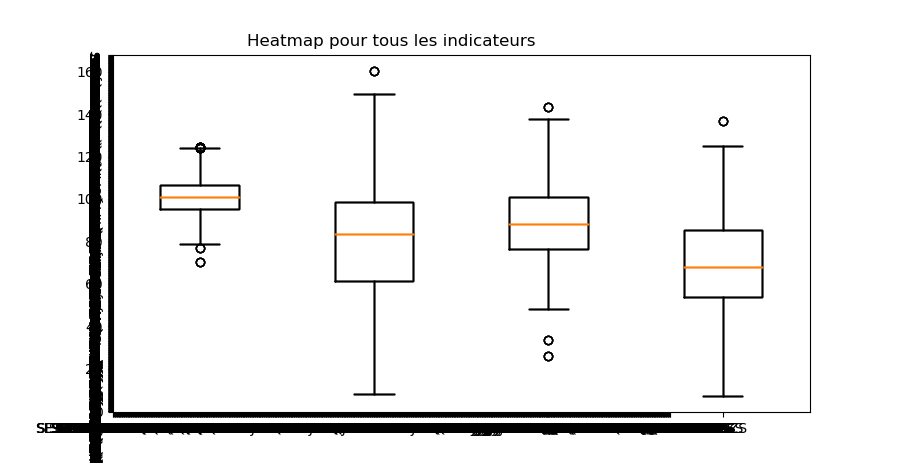

Text(0.5,1,'Heatmap pour tous les indicateurs')

In [8]:
#graphique des correlations entre les indicateurs
f, ax = plt.subplots()
corr = df_wb.corr()
_ = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
ax.set_title('Heatmap pour tous les indicateurs')

On fait une sélection des indicateurs parmi les mieux remplis pour faire une classification plus parlante.

<table><tr><th>Category</th><th>Indicator code</th><th>Indicator description</th></tr><tr><td>Education</td><td>SE.PRM.DURS</td><td>Primary education, duration (years)</td></tr><tr><td>Education</td><td>SE.PRE.DURS</td><td>Preprimary education, duration (years)</td></tr><tr><td>Education</td><td>SE.SEC.DURS</td><td>Secondary education, duration (years)</td></tr><tr><td>Environnement</td><td>SP.URB.TOTL.IN.ZS</td><td>Urban population (% of total)</td></tr><tr><td>Environnement</td><td>SP.URB.GROW</td><td>Urban population growth (annual %)</td></tr><tr><td>Environnement</td><td>AG.SRF.TOTL.K2</td><td>Surface area (sq. km)</td></tr><tr><td>Environnement</td><td>EN.POP.DNST</td><td>Population density (people per sq. km of land area)</td></tr><tr><td>Environnement</td><td>EN.ATM.NOXE.KT.CE</td><td>Nitrous oxide emissions (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>EN.ATM.METH.KT.CE</td><td>Methane emissions (kt of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>AG.LND.AGRI.K2</td><td>Agricultural land (sq. km)</td></tr><tr><td>Environnement</td><td>EN.ATM.GHGO.KT.CE</td><td>Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>AG.LND.AGRI.ZS</td><td>Agricultural land (% of land area)</td></tr><tr><td>Environnement</td><td>AG.PRD.FOOD.XD</td><td>Food production index (2004-2006 = 100)</td></tr><tr><td>Environnement</td><td>AG.PRD.LVSK.XD</td><td>Livestock production index (2004-2006 = 100)</td></tr><tr><td>Environnement</td><td>AG.PRD.CROP.XD</td><td>Crop production index (2004-2006 = 100)</td></tr><tr><td>Environnement</td><td>EN.ATM.GHGT.KT.CE</td><td>Total greenhouse gas emissions (kt of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.GF.ZS</td><td>CO2 emissions from gaseous fuel consumption (% of total)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.LF.ZS</td><td>CO2 emissions from liquid fuel consumption (% of total)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.SF.ZS</td><td>CO2 emissions from solid fuel consumption (% of total)</td></tr><tr><td>Environnement</td><td>NY.GDP.FRST.RT.ZS</td><td>Forest rents (% of GDP)</td></tr><tr><td>Environnement</td><td>NY.GDP.MINR.RT.ZS</td><td>Mineral rents (% of GDP)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.LF.KT</td><td>CO2 emissions from liquid fuel consumption (kt)</td></tr><tr><td>Environnement</td><td>EN.ATM.METH.AG.KT.CE</td><td>Agricultural methane emissions (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>EN.ATM.METH.EG.KT.CE</td><td>Methane emissions in energy sector (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>EN.ATM.NOXE.AG.KT.CE</td><td>Agricultural nitrous oxide emissions (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>EN.ATM.NOXE.EG.KT.CE</td><td>Nitrous oxide emissions in energy sector (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>NY.GDP.TOTL.RT.ZS</td><td>Total natural resources rents (% of GDP)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.KT</td><td>CO2 emissions (kt)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.PC</td><td>CO2 emissions (metric tons per capita)</td></tr><tr><td>Health</td><td>SP.POP.GROW</td><td>Population growth (annual %)</td></tr><tr><td>Health</td><td>SP.DYN.CBRT.IN</td><td>Birth rate, crude (per 1,000 people)</td></tr><tr><td>Health</td><td>SP.DYN.CDRT.IN</td><td>Death rate, crude (per 1,000 people)</td></tr><tr><td>Health</td><td>SP.DYN.TFRT.IN</td><td>Fertility rate, total (births per woman)</td></tr><tr><td>Health</td><td>SP.ADO.TFRT</td><td>Adolescent fertility rate (births per 1,000 women ages 15-19)</td></tr><tr><td>Health</td><td>SP.DYN.LE00.FE.IN</td><td>Life expectancy at birth, female (years)</td></tr><tr><td>Health</td><td>SP.DYN.LE00.IN</td><td>Life expectancy at birth, total (years)</td></tr><tr><td>Health</td><td>SP.POP.DPND</td><td>Age dependency ratio (% of working-age population)</td></tr><tr><td>Health</td><td>SP.DYN.AMRT.FE</td><td>Mortality rate, adult, female (per 1,000 female adults)</td></tr><tr><td>Health</td><td>SP.DYN.AMRT.MA</td><td>Mortality rate, adult, male (per 1,000 male adults)</td></tr><tr><td>Infrastructure</td><td>IT.CEL.SETS</td><td>Mobile cellular subscriptions</td></tr><tr><td>Infrastructure</td><td>IT.MLT.MAIN</td><td>Fixed telephone subscriptions</td></tr><tr><td>National_accounts</td><td>NY.ADJ.AEDU.GN.ZS</td><td>Adjusted savings: education expenditure (% of GNI)</td></tr><tr><td>National_accounts</td><td>NY.GDP.MKTP.CD</td><td>GDP (current USD)</td></tr><tr><td>National_accounts</td><td>NY.GDP.PCAP.CD</td><td>GDP per capita (current USD)</td></tr>
</table>

In [9]:
#limiter les variables pour la dernière année disponible, 2015
#year = 2015
#df_wb = df_wb[df_wb['year'] == year]

#finalement non : en liminant on obtient très peu de points et rien interprétable sur la clustering. 
#Du coup il y aura des pays qui changent de cluster au fil des années

In [10]:
indicators = ['SP.URB.TOTL.IN.ZS',	'SP.URB.GROW',	'SP.POP.GROW',	'SE.PRM.DURS',	'AG.SRF.TOTL.K2',	'SE.PRE.DURS',	'EN.POP.DNST',	'SE.SEC.DURS',	'SP.DYN.CBRT.IN',	'SP.DYN.CDRT.IN',	'NY.ADJ.AEDU.GN.ZS',	'SP.DYN.TFRT.IN',	'SP.ADO.TFRT',	'SP.DYN.LE00.FE.IN',	'SP.DYN.LE00.IN',	'SP.POP.DPND',	'SP.DYN.AMRT.FE',	'SP.DYN.AMRT.MA',	'EN.ATM.NOXE.KT.CE',	'EN.ATM.METH.KT.CE',	'AG.LND.AGRI.K2',	'EN.ATM.GHGO.KT.CE',	'AG.LND.AGRI.ZS',	'AG.PRD.FOOD.XD',	'IT.CEL.SETS',	'AG.PRD.LVSK.XD',	'AG.PRD.CROP.XD',	'IT.MLT.MAIN',	'EN.ATM.GHGT.KT.CE',	'EN.ATM.CO2E.GF.ZS',	'EN.ATM.CO2E.LF.ZS',	'EN.ATM.CO2E.SF.ZS',	'NY.GDP.FRST.RT.ZS',	'NY.GDP.MINR.RT.ZS',	'EN.ATM.CO2E.LF.KT',	'EN.ATM.METH.AG.KT.CE',	'EN.ATM.METH.EG.KT.CE',	'EN.ATM.NOXE.AG.KT.CE',	'EN.ATM.NOXE.EG.KT.CE',	'NY.GDP.TOTL.RT.ZS',	'EN.ATM.CO2E.KT',	'EN.ATM.CO2E.PC',	'NY.GDP.MKTP.CD',	'NY.GDP.PCAP.CD']
df_wb = df_wb[indicators + ['area', 'year']]

<IPython.core.display.Javascript object>


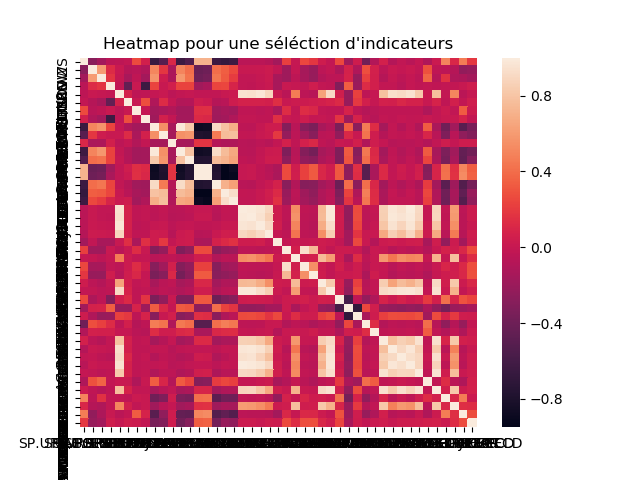

Text(0.5,1,"Heatmap pour une séléction d'indicateurs")

In [11]:
#graphique des correlations entre les indicateurs
f, ax = plt.subplots()
corr = df_wb.corr()
_ = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
ax.set_title("Heatmap pour une séléction d'indicateurs")

In [112]:
#standardiser les features pour la classification
from sklearn.preprocessing import StandardScaler
#remplacer les valeurs manquantes aussi par les méthodes forward et backward
X = df_wb[indicators].fillna(method='ffill').fillna(method='bfill')
X_std = StandardScaler().fit_transform(X)

<font color="#660066" size=6><u>
Analyse en Composantes Principales
</font></u>

In [113]:
from sklearn.decomposition import PCA
nb_features = X_std.shape[1]
pca = PCA(n_components=nb_features) #nombre maximal de composantes principales
projected = pca.fit_transform(X_std)

np.set_printoptions(precision=3) #affichage: nombre de décimales
np.set_printoptions(suppress=True) #affichage: éliminer notation scientifique pour les petits nombres
print('Pourcentage de variance expliquée par composante : ' , pca.explained_variance_ratio_)
print('Pourcentage cummulé de variance expliquée : ', np.cumsum(pca.explained_variance_ratio_))

Pourcentage de variance expliquée par composante :  [ 0.279  0.214  0.058  0.054  0.043  0.034  0.033  0.03   0.026  0.024
  0.022  0.018  0.017  0.016  0.015  0.014  0.013  0.012  0.01   0.009
  0.009  0.008  0.007  0.007  0.006  0.005  0.004  0.003  0.002  0.002
  0.002  0.001  0.001  0.001  0.001  0.001  0.001  0.     0.     0.     0.
  0.     0.     0.   ]
Pourcentage cummulé de variance expliquée :  [ 0.279  0.493  0.55   0.604  0.648  0.682  0.715  0.745  0.771  0.795
  0.817  0.835  0.852  0.868  0.884  0.897  0.91   0.922  0.932  0.941
  0.95   0.958  0.964  0.971  0.977  0.981  0.985  0.988  0.99   0.992
  0.993  0.994  0.996  0.997  0.998  0.998  0.999  0.999  1.     1.     1.
  1.     1.     1.   ]


<IPython.core.display.Javascript object>


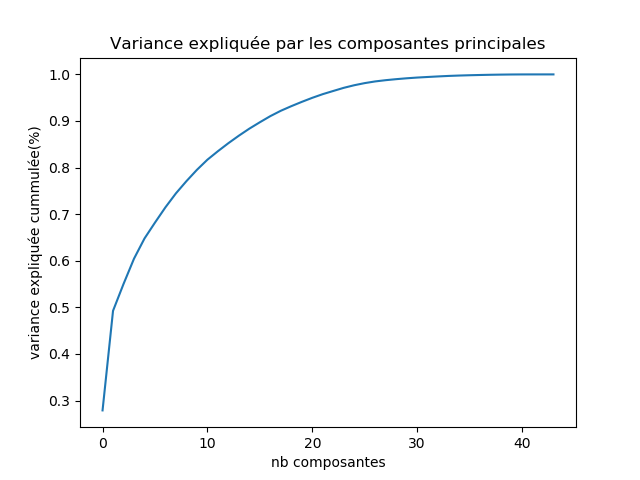

Text(0.5,1,'Variance expliquée par les composantes principales')

In [114]:
#nombre de composantes versus variance cummulée
plt.figure() #créer un nouveau graphique, ne pas remplacer le dernier
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('nb composantes')
plt.ylabel('variance expliquée cummulée(%)')
plt.title("Variance expliquée par les composantes principales")

On observe que la variance est générée par un nombre plus petit de composantes, donc il est raisonnable d'en retenir deux pour pouvoir projeter les pays dans un espace de dimension réduite.

<IPython.core.display.Javascript object>


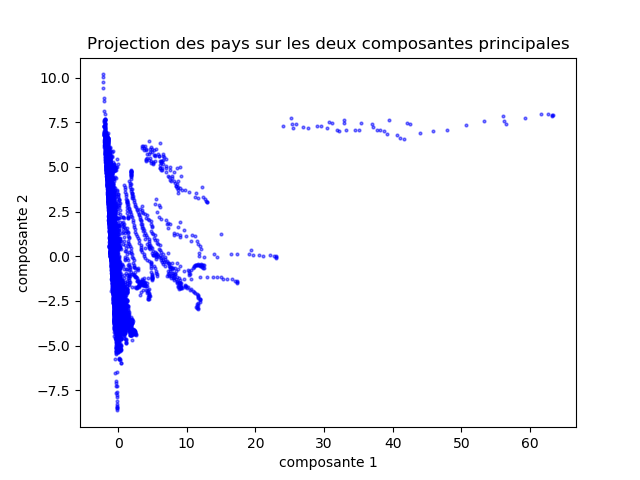

In [115]:
#ACP avec 2 composantes
pca = PCA(n_components=2) 
projected = pca.fit_transform(X_std)
#graphique des pays sur les deux composantes
plt.figure() 
plt.plot(projected[:, 0], projected[:, 1], 'o', markersize=2, color='blue', alpha=0.5)
plt.xlabel('composante 1')
plt.ylabel('composante 2')
plt.title('Projection des pays sur les deux composantes principales')
plt.show()

En utilisant cette projection des pays sur les deux composantes pricipales qui expliquent la moitié de la variance, on pourrait distinguer 4/5 groupes. Par la suite, on appliquera un algorithme KMeans pour identifier ces groupes de pays similaires.

<font color="#660066" size=6><u>
Clustering
</font></u>

In [116]:
#clustering des pays - KMeans
from sklearn.cluster import KMeans
clus = KMeans(4) #nombre de groupes
clus.fit(X_std)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
pred = clus.predict(X_std) #cluster prédit pour chaque point

In [117]:
#descriptions des clusters
clusters = pd.DataFrame({'Country':df_wb.index, 'group':pred})
groups = clusters.groupby('group')
groups.describe()

Country                                                                \
        count         mean          std     min      25%      50%       75%   
group                                                                         
0      3445.0  6046.711176  3455.375231    46.0  3052.00   6414.0   9163.00   
1      6070.0  5568.945964  3412.736788     0.0  2449.25   5459.5   8462.75   
2        46.0  4500.500000    13.422618  4478.0  4489.25   4500.5   4511.75   
3       340.0  8447.161765  3334.288254  1704.0  4568.75  10108.5  10569.25   

                
           max  
group           
0      11647.0  
1      11555.0  
2       4523.0  
3      11068.0

In [118]:
from sklearn.metrics import silhouette_score
ps = pd.DataFrame(projected) #transfromer array en data frame 

clusterer = KMeans(n_clusters=5).fit(ps)
centers = clusterer.cluster_centers_ #coordonnées des centres des clusters
c_preds = clusterer.predict(ps) #cluster prédit pour chaque point
print('Coordonnées des centres des clusters : \n ', centers)

Coordonnées des centres des clusters : 
  [[ -1.252   4.327]
 [  0.011  -2.723]
 [ 40.784   7.326]
 [ -0.673   0.417]
 [  8.721   0.699]]


<IPython.core.display.Javascript object>


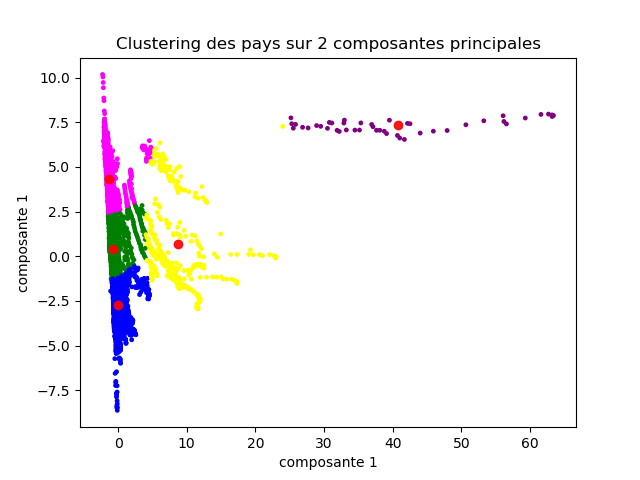

In [119]:
import matplotlib
fig = plt.figure()
colors = ['magenta','blue','purple','green', 'yellow']
colored = [colors[k] for k in c_preds]
plt.scatter(ps[0],ps[1],s=6,  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=6, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('composante 1')
plt.ylabel('composante 1')
plt.title('Clustering des pays sur 2 composantes principales')
plt.show()

In [120]:
#ajouter le cluster prédit aux tableau initial
df_wb = df_wb.copy()
df_wb['cluster'] = c_preds

#df_wb[df_wb.area == 'France'] #la france ne change pas de cluster
df_wb.head(10)

,SP.URB.TOTL.IN.ZS,SP.URB.GROW,SP.POP.GROW,SE.PRM.DURS,AG.SRF.TOTL.K2,SE.PRE.DURS,EN.POP.DNST,SE.SEC.DURS,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,...,EN.ATM.NOXE.AG.KT.CE,EN.ATM.NOXE.EG.KT.CE,NY.GDP.TOTL.RT.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.PC,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,area,year,cluster
0,50.624,0.549986,0.579003,6.0,180.0,2.0,328.138889,5.0,24.099,5.671,...,0.706316,0.367760,NaN,NaN,NaN,NaN,NaN,Aruba,1970,3
1,50.609,0.600182,0.629522,6.0,180.0,2.0,330.211111,5.0,23.505,5.698,...,0.701674,0.367675,NaN,NaN,NaN,NaN,NaN,Aruba,1971,3
2,50.593,0.656066,0.689097,6.0,180.0,2.0,332.494444,5.0,23.068,5.746,...,0.704372,0.367683,NaN,NaN,NaN,NaN,NaN,Aruba,1972,3
3,50.578,0.622255,0.649526,6.0,180.0,2.0,334.661111,5.0,22.760,5.812,...,0.700662,0.376658,NaN,NaN,NaN,NaN,NaN,Aruba,1973,3
4,50.563,0.442109,0.473652,6.0,180.0,2.0,336.250000,5.0,22.561,5.892,...,0.699875,0.374573,NaN,NaN,NaN,NaN,NaN,Aruba,1974,1
5,50.548,0.186083,0.214557,6.0,180.0,2.0,336.972222,5.0,22.452,5.981,...,0.704201,0.375536,NaN,NaN,NaN,NaN,NaN,Aruba,1975,1
6,50.532,-0.140346,-0.108871,6.0,180.0,2.0,336.605556,5.0,22.414,6.070,...,0.702771,0.597055,NaN,NaN,NaN,NaN,NaN,Aruba,1976,1
7,50.517,-0.399267,-0.368733,6.0,180.0,2.0,335.366667,5.0,22.424,6.157,...,0.709692,0.600722,NaN,NaN,NaN,NaN,NaN,Aruba,1977,1
8,50.502,-0.460149,-0.431636,6.0,180.0,2.0,333.922222,5.0,22.454,6.237,...,0.706671,1.303366,NaN,NaN,NaN,NaN,NaN,Aruba,1978,1
9,50.487,-0.244080,-0.213184,6.0,180.0,2.0,333.211111,5.0,22.478,6.309,...,0.709329,1.532186,NaN,NaN,NaN,NaN,NaN,Aruba,1979,1


In [35]:
print('Pays qui change de cluster:')
df_wb[df_wb.area == 'India'][['area', 'year', 'cluster']]

Pays qui change de cluster:


,area,year,cluster
4708,India,1970,0
4709,India,1971,0
4710,India,1972,0
4711,India,1973,0
4712,India,1974,0
4713,India,1975,0
4714,India,1976,0
4715,India,1977,0
4716,India,1978,0
4717,India,1979,0


In [36]:
print('Pays qui ne change pas de cluster:')
df_wb[df_wb.area == 'France'][['area', 'year', 'cluster']]

Pays qui ne change pas de cluster:


,area,year,cluster
3378,France,1970,1
3379,France,1971,1
3380,France,1972,1
3381,France,1973,1
3382,France,1974,1
3383,France,1975,1
3384,France,1976,1
3385,France,1977,1
3386,France,1978,1
3387,France,1979,1


Au fil des années, certains pays peuvent voir leur situation économique, démographique ou écologique changer, ce qui se traduit par un changement de group auquel ils appartiennent - c'est l'exemple de l'Inde. 

En revanche, un pays plus stable comme la France ne voit pas une évolution similaire - elle reste dans le meme groupe pour toutes les années enregistrées. 

## Analyse des clusters obtenus

In [58]:
#moyennes des indicateurs par cluster
c0 = df_wb[df_wb['cluster']==0].drop('cluster',axis=1).mean()
c1 = df_wb[df_wb['cluster']==1].drop('cluster',axis=1).mean()
c2 = df_wb[df_wb['cluster']==2].drop('cluster',axis=1).mean()
c3 = df_wb[df_wb['cluster']==3].drop('cluster',axis=1).mean()

c0

SP.URB.TOTL.IN.ZS       2.752617e+01
SP.URB.GROW             4.844015e+00
SP.POP.GROW             2.694831e+00
SE.PRM.DURS             5.979968e+00
AG.SRF.TOTL.K2          6.650054e+05
SE.PRE.DURS             2.632212e+00
EN.POP.DNST             5.849334e+01
SE.SEC.DURS             6.221755e+00
SP.DYN.CBRT.IN          4.356230e+01
SP.DYN.CDRT.IN          1.548077e+01
NY.ADJ.AEDU.GN.ZS       3.322526e+00
SP.DYN.TFRT.IN          6.265827e+00
SP.ADO.TFRT             1.324776e+02
SP.DYN.LE00.FE.IN       5.240897e+01
SP.DYN.LE00.IN          5.100859e+01
SP.POP.DPND             9.291614e+01
SP.DYN.AMRT.FE          3.338366e+02
SP.DYN.AMRT.MA          3.850064e+02
EN.ATM.NOXE.KT.CE       1.004053e+04
EN.ATM.METH.KT.CE       2.203317e+04
AG.LND.AGRI.K2          2.438411e+05
EN.ATM.GHGO.KT.CE       4.640925e+04
AG.LND.AGRI.ZS          4.112529e+01
AG.PRD.FOOD.XD          6.770752e+01
IT.CEL.SETS             1.242359e+06
AG.PRD.LVSK.XD          6.889594e+01
AG.PRD.CROP.XD          6.811196e+01
I

In [77]:
clus_moy = pd.concat([c0, c1, c2, c3], axis=1)
clus_moy

,0,1,2,3
SP.URB.TOTL.IN.ZS,2.752617e+01,6.882650e+01,3.670490e+01,5.181363e+01
SP.URB.GROW,4.844015e+00,1.331979e+00,3.087174e+00,2.784553e+00
SP.POP.GROW,2.694831e+00,9.136778e-01,1.762181e+00,1.965525e+00
SE.PRM.DURS,5.979968e+00,5.359456e+00,6.000000e+00,5.772644e+00
AG.SRF.TOTL.K2,6.650054e+05,7.889508e+05,9.849881e+07,4.869378e+05
SE.PRE.DURS,2.632212e+00,2.814097e+00,3.000000e+00,2.439803e+00
EN.POP.DNST,5.849334e+01,6.577702e+02,4.616242e+01,2.147915e+02
SE.SEC.DURS,6.221755e+00,6.641536e+00,6.011364e+00,6.164486e+00
SP.DYN.CBRT.IN,4.356230e+01,1.558634e+01,2.733755e+01,2.949407e+01
SP.DYN.CDRT.IN,1.548077e+01,8.044030e+00,9.584249e+00,7.545853e+00


In [101]:
m0 = df_wb[df_wb['cluster']==0]['NY.GDP.MKTP.CD'].values
m1 = df_wb[df_wb['cluster']==1]['NY.GDP.MKTP.CD'].values
m2 = df_wb[df_wb['cluster']==2]['NY.GDP.MKTP.CD'].values
m3 = df_wb[df_wb['cluster']==3]['NY.GDP.MKTP.CD'].values

data_to_plot = [m0, m1, m2, m3]
data_to_plot

[array([  1.749e+09,   1.831e+09,   1.596e+09, ...,   1.239e+10,
          1.349e+10,   1.420e+10]),
 array([        nan,         nan,         nan, ...,   1.936e+11,
          8.004e+08,   7.610e+08]),
 array([  6.129e+11,   6.624e+11,   7.382e+11,   9.371e+11,   1.192e+12,
          1.304e+12,   1.414e+12,   1.596e+12,   1.731e+12,   2.065e+12,
          2.421e+12,   2.609e+12,   2.582e+12,   2.523e+12,   2.557e+12,
          2.692e+12,   2.814e+12,   2.898e+12,   3.136e+12,   3.336e+12,
          3.754e+12,   4.032e+12,   4.007e+12,   4.271e+12,   4.639e+12,
          5.219e+12,   5.699e+12,   6.023e+12,   5.855e+12,   5.708e+12,
          6.214e+12,   6.283e+12,   6.403e+12,   7.231e+12,   8.586e+12,
          1.024e+13,   1.214e+13,   1.501e+13,   1.803e+13,   1.752e+13,
          2.135e+13,   2.518e+13,   2.667e+13,   2.826e+13]),
 array([        nan,         nan,         nan, ...,   8.286e+09,
          8.784e+09,   1.442e+10])]

<IPython.core.display.Javascript object>


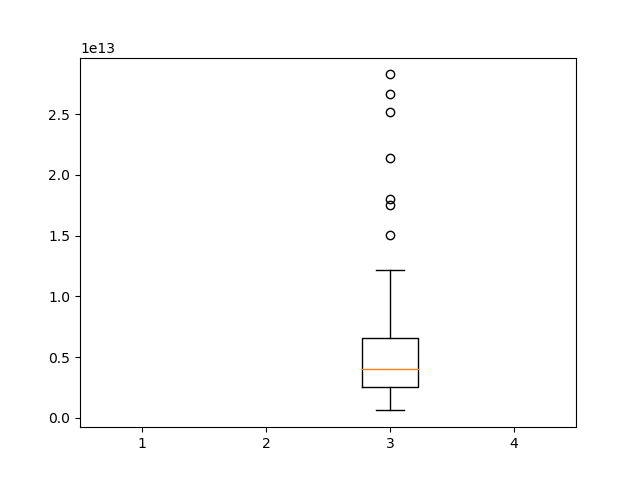

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1857: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1864: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1872: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1873: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


In [102]:
plt.figure()
plt.boxplot(data_to_plot)

plt.show()

In [103]:
m0

array([  1.749e+09,   1.831e+09,   1.596e+09, ...,   1.239e+10,
         1.349e+10,   1.420e+10])

In [106]:
np.isnan(m0).sum()

412